In [ ]:
import numpy as np
np.random.seed(12345)
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
np.set_printoptions(precision=4, suppress=True)
import pandas as pd
from pandas import Series, DataFrame, RangeIndex
import seaborn as sns

# Datasets

In [ ]:
covid_data = pd.read_csv("https://opendata.ecdc.europa.eu/covid19/vaccine_tracker/csv/data.csv")

In [ ]:
covid_data_2 = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv")

In [ ]:
covid_data_3 = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv")
covid_data_mp = covid_data_3[['continent', 'location', 'date', 'total_cases','iso_code']]

In [ ]:
policies_data = pd.read_csv("https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2,3,41,42) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
mobility_data=pd.read_csv("https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv",usecols=[1,8,9,10,11,12,13,14])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
baseDir = '/content/drive/MyDrive'
occupation_data = pd.read_csv(baseDir+'/DP_LIVE_09022022124043650.csv')

Mounted at /content/drive


In [ ]:
int_stat = ['Hungary','Italy','Finland']

# Functions 

In [ ]:
def xticks_details(xticks,ax,step,rotation):
  if step != 0:
    ax.set_xticks(range(0,len(xticks),step))
    ax.set_xticklabels(xticks[0:len(xticks):step], rotation=rotation)
  else:
    ax.set_xticks(range(len(xticks)))
    ax.set_xticklabels(xticks)

In [ ]:
def get_outliers_labels(df, list_of_values = None):
  label=[]
  if list_of_values != None:
    for value in list_of_values:
      i = np.where(df['people_fully_vaccinated_per_hundred'] == value)
      a = df.iloc[i].index.get_level_values('location')
      label.extend(list(a))
  return label

In [ ]:
def distribution_analysis(vars,graph_title,get_out_names = None):
  fig = plt.figure(figsize = (18,5))
  title = ('Distribution of vaccinated people (percentage) {}'.format(graph_title))
  fig.suptitle(title, fontsize = 20, color='maroon')
  ax= fig.add_subplot(1,2,1)
  vars.hist(bins=30, ax = ax, grid = False, color='grey')
  ax.set_xticks(range(0,100,5))
  ax.set_yticks(range(0,16,1))
  ax.vlines(vars.mean(), ymin=0, ymax=15, color='limegreen', label='average')
  ax.vlines(vars.median(), ymin=0, ymax=15, color='red', label='median')
  ax.legend(loc='best')
  ax2 = fig.add_subplot(1,2,2)
  boxplt = plt.boxplot(vars['people_fully_vaccinated_per_hundred'])
  out = list(boxplt["fliers"][0].get_data()[1])
  if len(out) != 0:
    outliers = get_outliers_labels(vars, list_of_values = out)
    new = list(zip(out,outliers))
    for coord,name in new:
      ax2.annotate(name, xy=(1, coord), xytext=(1.01, coord))
  if get_out_names != None:
    return print('Outliers: ', outliers)

In [ ]:
def make_linear_regression (df,x_name,y_name):
  from sklearn.linear_model import LinearRegression
  data = df[[x_name,y_name]].dropna()
  x = np.array(np.log(data[x_name])).reshape(-1,1)
  y = np.array(np.log(data[y_name])).reshape(-1,1)
  model = LinearRegression(fit_intercept=True).fit(x, y)
  return model.coef_

def coeff_df (df, loc_col, state, y_vars, x_name):
    beta = []
    y_fin = []
    for y in y_vars:
      try:
        coef = make_linear_regression(df[df[loc_col]== state], x_name = x_name, y_name=y)
        beta.append(round(float(coef),3))
        y_fin.append(y)
      except:
        continue
    obj = {'Dependant_variables':y_fin,'Beta_hat': beta} 
    return pd.DataFrame(obj)

In [ ]:
def subclass_plot(int_vars, list_states, index_name):
  fig = plt.figure(figsize = (28,48))
  title = ("Analysis of subcategories of {} in each country"). format(index_name)
  fig.suptitle(title, fontsize = 20, color='maroon')
  i=1
  while i < len(int_vars.columns):
    for el in list(int_vars.keys()):
      ax = fig.add_subplot(5,2,i)
      ax.set_title(el, color = 'maroon', fontsize = 15)
      obj = int_vars.loc[list_states,:].reset_index().groupby('CountryName').apply(lambda x: x.groupby(pd.Grouper(key ='Date', freq='1M')).mean())
      obj.reset_index().set_index(['Date','CountryName']).unstack()[el].plot.bar(legend =True, ax=ax, color = ['tab:blue','tab:olive','tab:red'])
      xticks = list(obj.reset_index().set_index(['Date']).index.unique().date)
      xticks_details(xticks,ax,0,90)
      ax.legend(loc='best')
      i+=1

# General overview of pandemics

#### Mapping incidence of pandemic


In [ ]:
# 'covid map' dataframe is created in Datasets section
covid_map = covid_data_mp.rename(columns={
    'location': 'country',
    'total_cases': 'cases'
})
covid_map.dropna(inplace = True)
covid_map['date'] = pd.to_datetime(covid_data_mp['date'], format='%Y-%m-%d')

In [ ]:
# the code computes the map considering the day before it is launched 
from datetime import datetime, timedelta
int_date = datetime.strftime(datetime.now() - timedelta(1), '%Y-%m-%d')
covid_map_fin = covid_map[covid_map.date == int_date]
covid_map_fin.sample(10)

,continent,country,date,cases,iso_code
54964,South America,Falkland Islands,2022-04-11,129.0,FLK
131783,Asia,Qatar,2022-04-11,362937.0,QAT
111322,Asia,Myanmar,2022-04-11,612383.0,MMR
130242,Europe,Portugal,2022-04-11,3686491.0,PRT
73966,Europe,Iceland,2022-04-11,183363.0,ISL
55767,Oceania,Fiji,2022-04-11,64499.0,FJI
57380,Europe,France,2022-04-11,27026432.0,FRA
43417,Europe,Denmark,2022-04-11,3086959.0,DNK
38021,Africa,Cote d'Ivoire,2022-04-11,81829.0,CIV
116315,North America,Nicaragua,2022-04-11,18491.0,NIC


In [ ]:
import plotly.express as px
fig = px.scatter_geo(
    covid_map_fin, 
    locations = 'iso_code',
    color = 'continent',
    hover_name = 'country',
    size = 'cases',
    projection = "equirectangular",
    title = f'World COVID-19 Cases for {int_date}'
)
fig.show()

### Countries reaction to the evolution of pandemic

In [ ]:
policies_data['Date'] = pd.to_datetime(policies_data['Date'], format='%Y%m%d')

In [ ]:
overview_pol = policies_data.set_index(['Date','CountryName']).filter(regex='Display$', axis=1).reset_index().drop(['StringencyLegacyIndexForDisplay'], axis=1)

# in the original dataset are included indices related to the responses of governments to pandemic, but also all their components
# so, I use the regular expression to select only the columns related to the indexes themselves and drop, besides all components, also the legacy index because it is not interesting
# and has the same information load as normal stringency

cases = covid_data_3[['location', 'date', 'new_cases_smoothed']].rename(columns ={'date':'Date','location': 'CountryName','new_cases_smoothed':'daily_cases' })
cases['Date'] = pd.to_datetime(cases['Date'], format='%Y-%m-%d')
new_data = pd.merge(cases,overview_pol, on = ['Date','CountryName']).set_index(['CountryName','Date'])

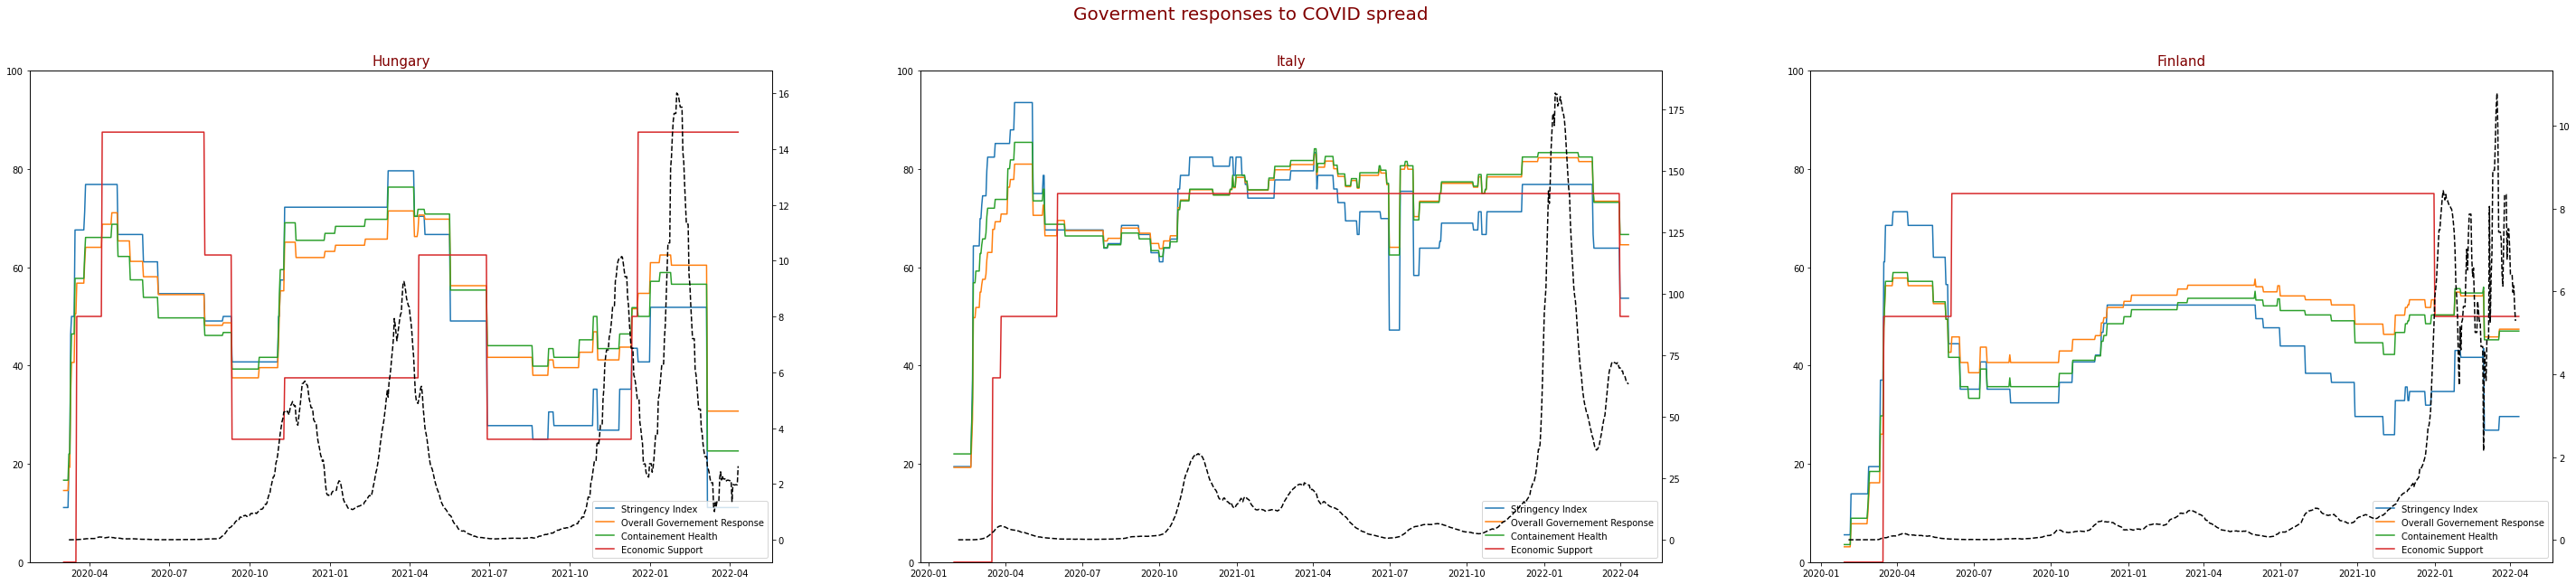

In [ ]:
fig = plt.figure(figsize = (50,10))
i=1
fig.suptitle('Goverment responses to COVID spread', fontsize = 20, color='maroon')
for state in int_stat:
    c_foc = new_data.loc[state,:] 
    while i < 4:
      ax = fig.add_subplot(1,3,i)
      ax2 = ax.twinx()
      ax2.plot(c_foc['daily_cases']/(1000), 'k--', label = 'daily cases')
      ax.plot(c_foc.drop(['daily_cases'],axis=1)['StringencyIndexForDisplay'], label ='Stringency Index')
      ax.plot(c_foc.drop(['daily_cases'],axis=1)['GovernmentResponseIndexForDisplay'], label ='Overall Governement Response')
      ax.plot(c_foc.drop(['daily_cases'],axis=1)['ContainmentHealthIndexForDisplay'], label ='Containement Health')
      ax.plot(c_foc.drop(['daily_cases'],axis=1)['EconomicSupportIndexForDisplay'], label ='Economic Support')
      ax.legend(loc='lower right')
      ax.set_ylim([0,100])
      ax.set_title(state, color = 'maroon', fontsize = 15)
      break
    i += 1

Stringency index analysis

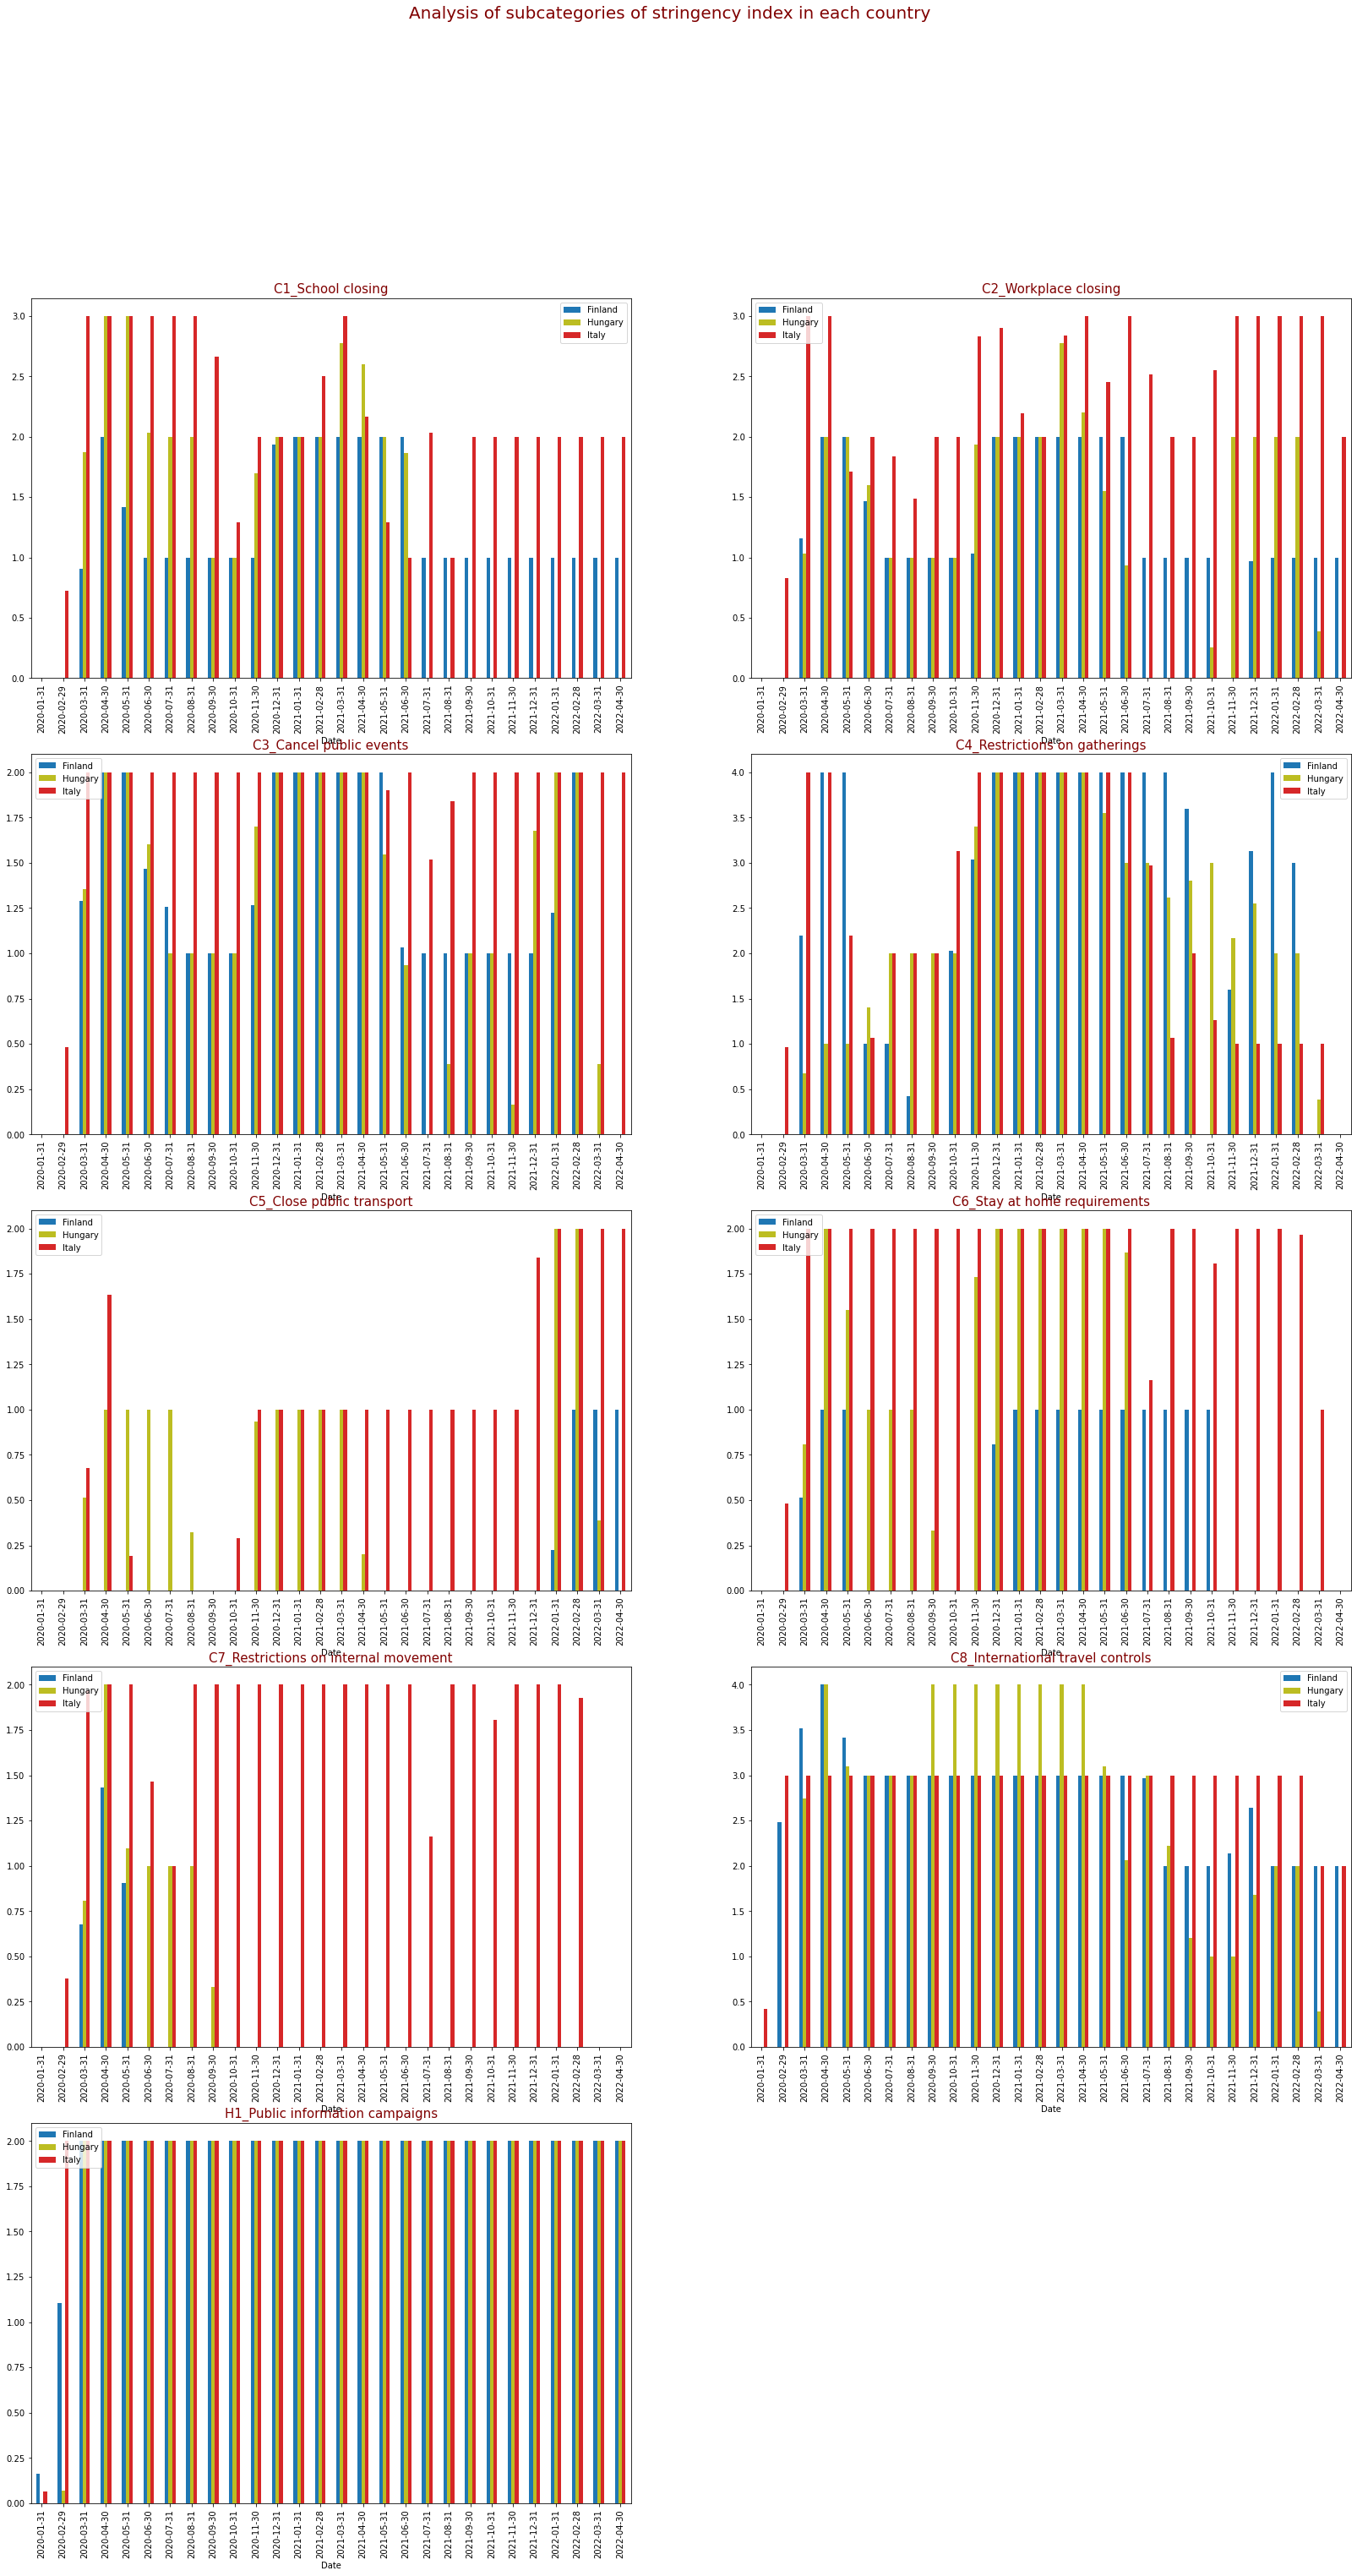

In [ ]:
cont_var = policies_data.set_index(['CountryName','Date']).filter(regex='^C[0-9]_[^F]', axis=1) 
# I created a regular expression to find all the columns related to the variables that were used to create the stringency index (variables starting with C, and not an F after the underscore in order to avoid the 'Flag' variables)
oth_var = policies_data[['Date','H1_Public information campaigns','CountryName']].set_index(['CountryName','Date'])
stringency_var = cont_var.join(oth_var)
subclass_plot(int_vars = stringency_var, list_states = int_stat,index_name = 'stringency index')

Economic support Index analysis

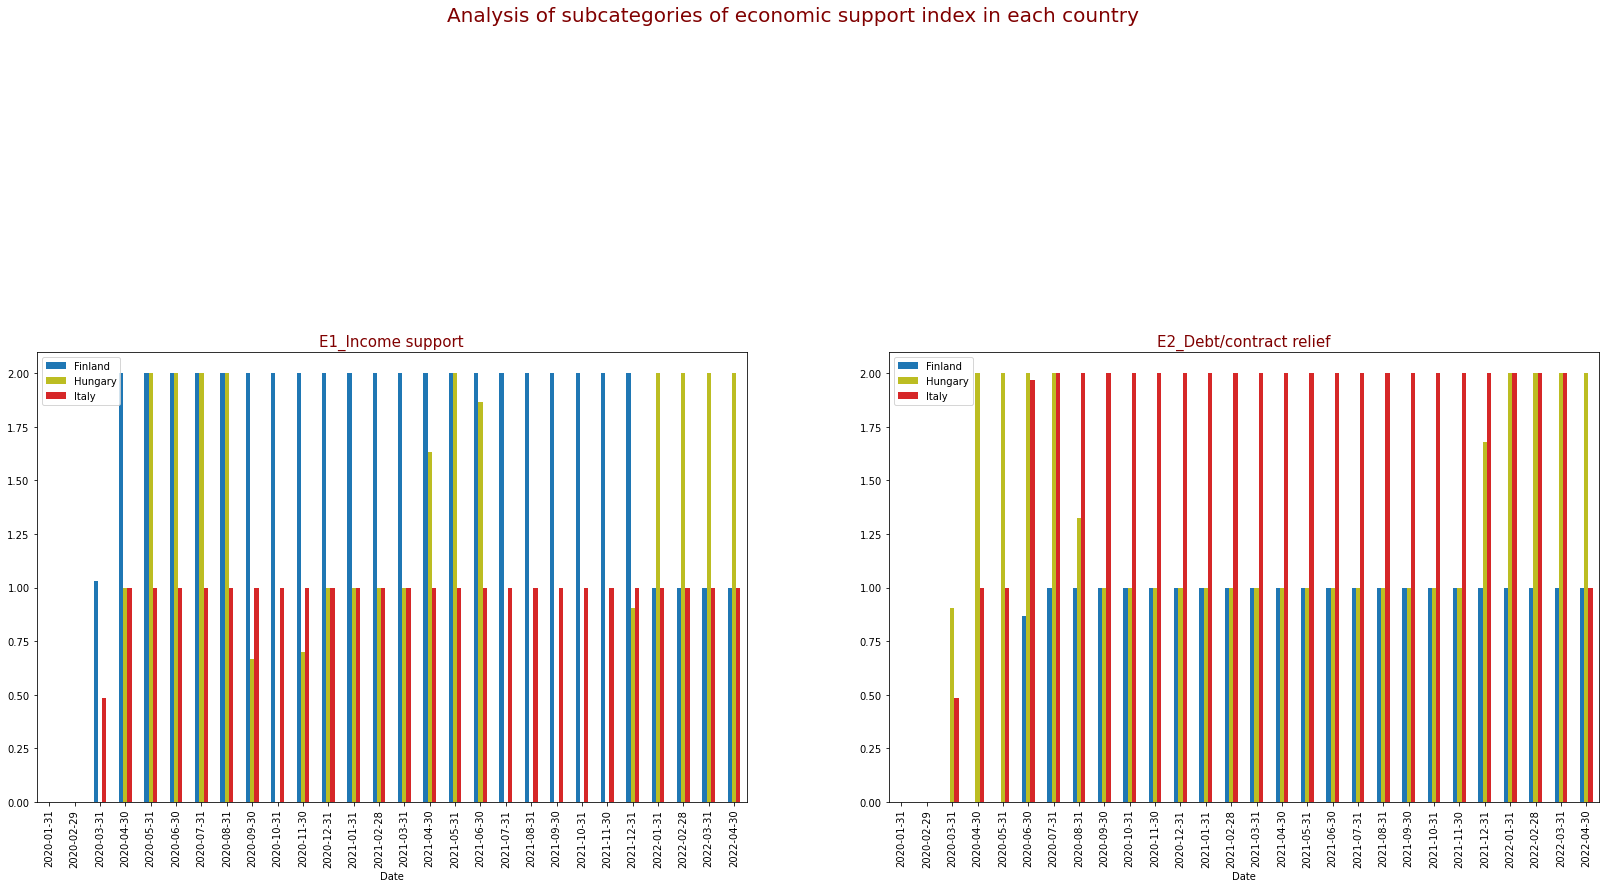

In [ ]:
ec_support_var = policies_data[['CountryName','Date','E1_Income support','E2_Debt/contract relief']].set_index(['CountryName','Date'])
subclass_plot(ec_support_var, int_stat, 'economic support index')

In [ ]:
# Manipulating occupation dataset in order to obtain differents dataframes used for graphical visualization

occupation_data_three = occupation_data.set_index('LOCATION').loc[['ITA','FIN','HUN']].reset_index() # COUNTRIES OF INTEREST WITH ALL VARIABLES
occupation_data_three = occupation_data_three.set_index('LOCATION').rename(columns={'Value':'Unemployment_percentage','TIME':'Month'},index={'FIN':'Finland','HUN':'Hungary','ITA':'Italy'}).reset_index()
occupation_data_three = occupation_data_three.rename(columns={'LOCATION':'Country'})

# Obtaining dataset to merge and dropping the rows before 2020-01
occupation_data_merge = occupation_data_three[['Country','Month','Unemployment_percentage']] 
occupation_data_merge = occupation_data_merge.set_index('Month').sort_values(by = ['Month','Country']).reset_index()
occupation_data_merge.drop(index=occupation_data_merge.index[:36],inplace=True)
occupation_data_merge = occupation_data_merge.reset_index().drop('index',axis=1)





,Month,Country,Unemployment_percentage
0,2020-01,Finland,6.8
1,2020-01,Hungary,3.6
2,2020-01,Italy,9.6
3,2020-02,Finland,6.6
4,2020-02,Hungary,3.5
...,...,...,...
67,2021-11,Hungary,3.8
68,2021-11,Italy,9.1
69,2021-12,Finland,7.2
70,2021-12,Hungary,3.7


In [ ]:
# Manipulating policies dataset 

policies_data['Date'] = pd.to_datetime(policies_data['Date'], format='%Y%m%d') 
policies_data_three = policies_data.set_index('CountryCode').loc[['ITA','FIN','HUN']].reset_index()
policies_data_merge = policies_data_three[['CountryCode','Date','E1_Income support','GovernmentResponseIndex','EconomicSupportIndex']]
policies_tomerge_grouped = policies_data_merge.groupby([pd.Grouper(key='Date',freq='M'),'CountryCode']).mean().reset_index().rename(columns ={'Date':'Month','CountryCode':'Country'})

In [ ]:
# joined dataset

joined_data = policies_tomerge_grouped.join(occupation_data_merge['Unemployment_percentage'])
joined_data = joined_data.rename(index={'FIN':'Finland','HUN':'Hungary','ITA':'Italy'})
joined_data.set_index('Country').rename(index={'FIN':'Finland','HUN':'Hungary','ITA':'Italy'})

,Month,E1_Income support,GovernmentResponseIndex,EconomicSupportIndex,Unemployment_percentage
Country,,,,,
Finland,2020-01-31,0.0,0.503226,0.0,6.8
Hungary,2020-01-31,0.0,0.806452,0.0,3.6
Italy,2020-01-31,0.0,1.125161,0.0,9.6
Finland,2020-02-29,0.0,7.828276,0.0,6.6
Hungary,2020-02-29,0.0,6.609310,0.0,3.5
...,...,...,...,...,...
Hungary,2022-03-31,2.0,36.476452,87.5,NaN
Italy,2022-03-31,1.0,73.440000,75.0,NaN
Finland,2022-04-30,1.0,47.400000,50.0,NaN


Country
Finland    AxesSubplot(0.125,0.125;0.775x0.755)
Hungary    AxesSubplot(0.125,0.125;0.775x0.755)
Italy      AxesSubplot(0.125,0.125;0.775x0.755)
Name: Unemployment_percentage, dtype: object

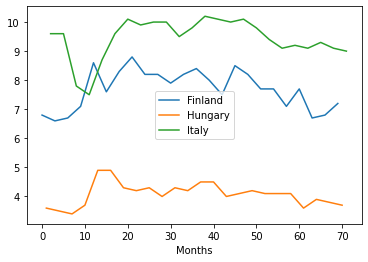

In [ ]:
# UNEMPLOYMENT PERCENTAGE DURING COVID
occupation_data_merge.groupby('Country')['Unemployment_percentage'].plot(x = 'Month',legend=True, xlabel = 'Months')

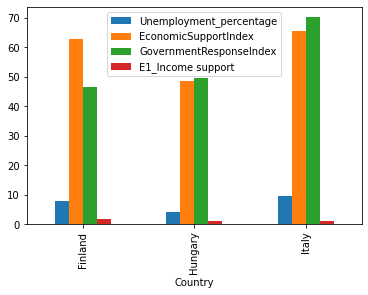

In [ ]:
import seaborn as sns

policies_data_merge_grouped = policies_data_merge.groupby('CountryCode').mean()
policies_data_merge_grouped

occupation_data_grouped = occupation_data_merge.groupby('Country').mean()
occupation_data_grouped


policies_data_merge_grouped = policies_data_merge_grouped.rename(index={'FIN':'Finland','HUN':'Hungary','ITA':'Italy'})
merged_aggregated = pd.merge(policies_data_merge_grouped,occupation_data_grouped,left_index=True, right_index=True)

merged_aggregated_plot = merged_aggregated.reset_index()
merged_aggregated_plot = merged_aggregated_plot[['CountryCode','Unemployment_percentage','EconomicSupportIndex','GovernmentResponseIndex','E1_Income support']]
merged_aggregated_plot.set_index('CountryCode').plot(kind = 'bar', xlabel = 'Country')


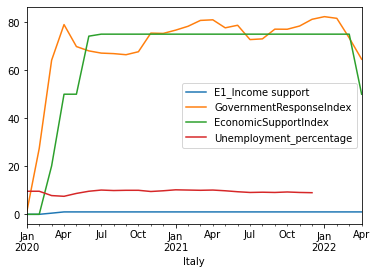

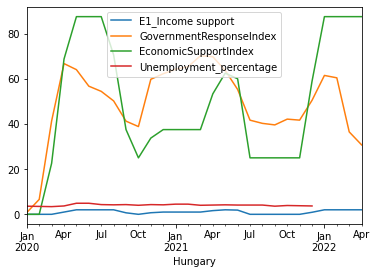

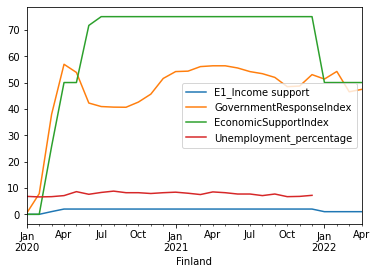

In [ ]:
joined_ita = joined_data.set_index('Country').loc[['ITA']].reset_index()
joined_ita.plot(x = 'Month',xlabel='Italy')

joined_hun = joined_data.set_index('Country').loc[['HUN']].reset_index()
joined_hun.plot(x = 'Month',xlabel='Hungary')

joined_fin = joined_data.set_index('Country').loc[['FIN']].reset_index()
joined_fin.plot(x = 'Month',xlabel='Finland')

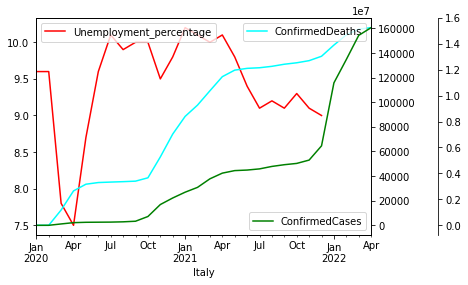

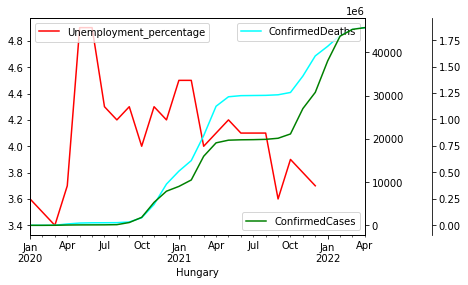

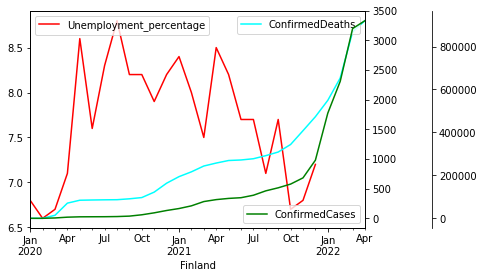

In [ ]:
policies_two = policies_data_three[['CountryCode','Date','ConfirmedCases','ConfirmedDeaths']]
policies_two = policies_two.groupby([pd.Grouper(key='Date',freq='M'),'CountryCode']).max().reset_index().rename(columns ={'Date':'TIME','CountryCode':'LOCATION'})

joined_datatwo = policies_two.join(occupation_data_merge['Unemployment_percentage']) 
joined_datatwo = joined_datatwo.set_index('LOCATION').rename(columns={'Value':'Unemployment_percentage','TIME':'Month'},index={'FIN':'Finland','HUN':'Hungary','ITA':'Italy'})
joined_datatwo = joined_datatwo.reset_index().rename(columns={'LOCATION':'Country'}).set_index('Country')


# PLOT ITALY
joined_ITA = joined_datatwo.loc[['Italy']]

plotting_1 = joined_ITA.drop(['ConfirmedCases','ConfirmedDeaths'],axis=1)
plotting_2 = joined_ITA.drop(['ConfirmedCases','Unemployment_percentage'],axis=1)
plotting_3 = joined_ITA.drop(['ConfirmedDeaths','Unemployment_percentage'],axis=1)

ax1 = plotting_1.plot(x = 'Month', color="red", xlabel = 'Italy')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
plotting_2.plot(x = 'Month',ax=ax2, color="cyan")
ax2.legend(loc='upper right')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('axes', 1.2))
plotting_3.plot(x = 'Month',ax=ax3, color="green")
ax3.legend(loc='lower right')

# PLOT HUNGARY

joined_HUN = joined_datatwo.loc[['Hungary']]

plotting_1 = joined_HUN.drop(['ConfirmedCases','ConfirmedDeaths'],axis=1)
plotting_2 = joined_HUN.drop(['ConfirmedCases','Unemployment_percentage'],axis=1)
plotting_3 = joined_HUN.drop(['ConfirmedDeaths','Unemployment_percentage'],axis=1)

ax1 = plotting_1.plot(x = 'Month', color="red", xlabel = 'Hungary')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
plotting_2.plot(x = 'Month',ax=ax2, color="cyan")
ax2.legend(loc='upper right')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('axes', 1.2))
plotting_3.plot(x = 'Month',ax=ax3, color="green")
ax3.legend(loc='lower right')

# PLOT FINLAND

joined_FIN = joined_datatwo.loc[['Finland']]

plotting_1 = joined_FIN.drop(['ConfirmedCases','ConfirmedDeaths'],axis=1)
plotting_2 = joined_FIN.drop(['ConfirmedCases','Unemployment_percentage'],axis=1)
plotting_3 = joined_FIN.drop(['ConfirmedDeaths','Unemployment_percentage'],axis=1)

ax1 = plotting_1.plot(x = 'Month', color="red", xlabel = 'Finland')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
plotting_2.plot(x = 'Month',ax=ax2, color="cyan")
ax2.legend(loc='upper right')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('axes', 1.2))
plotting_3.plot(x = 'Month',ax=ax3, color="green")
ax3.legend(loc='lower right')

# Analysis of vaccines spread 

### World's percentage of vaccinated people

In [ ]:
grouped_2 = covid_data_2[['date', 'location','people_fully_vaccinated_per_hundred']].groupby(['location'])
ord_totals= grouped_2.apply(lambda x: (x[['date','people_fully_vaccinated_per_hundred']].iloc[-7])).dropna().sort_values(by='people_fully_vaccinated_per_hundred', ascending=False)
# the programme takes into account the data relative to the week before it is runned; I do so in order to avoid problems related to the different timing of data collection and communication among countries
fig = plt.figure(figsize = (40,40))
ax1 = fig.add_subplot(1,1,1)
graph_1 = ord_totals['people_fully_vaccinated_per_hundred'].plot.barh(figsize=(20,20), ax = ax1)
for i in graph_1.patches:
    plt.text(i.get_width(), i.get_y()+0.1,
             str(round((i.get_width()), 2)),
             fontsize = 7, fontweight ='bold',
             color ='k')
# for each patch in my graph I take as coordinates of the text I'm going to write the width and the y coordinate (increased by 0.1 to centre the value written)
# and as the body of the text I use the length of the bar (which represents the percentage)
graph_1.set_title('Percentage of fully vaccinated people per country', loc='center', fontsize = 15, fontweight ='bold', color='maroon')
plt.xlim(0,100)
ax1.legend()

### Distribution analysis of percentage of vaccinated people across the world

In [ ]:
grouped_3 = covid_data_2[['date', 'location','people_fully_vaccinated_per_hundred','continent']].groupby(['continent','location'])
totals_3= grouped_3.apply(lambda x: (x[['date','people_fully_vaccinated_per_hundred']].iloc[-7])).dropna().drop(['date'],axis=1)

In [ ]:
distribution_analysis(totals_3, graph_title='in the world', get_out_names = 'Yes')

In [ ]:
continents = ['Africa', 'Asia','South America','Europe', 'North America', 'Oceania']
for continent in continents:
  ter = totals_3.loc[continent]
  obj = 'in {}'.format(continent)
  distribution_analysis(vars = ter,graph_title = obj)

### Distribution of vaccines among EU by manufacturer

In [ ]:
states = covid_data.set_index('ReportingCountry').index.unique()
covid_data_reg = covid_data.set_index('Region').loc[states]
abb_to_name = {'AT': 'Austria', 'BE': 'Belgium', 'BG':'Bulgaria', 'CY':'Cyprus', 'CZ': 'Czech Republic', 'DE': 'Germany', 'DK':'Denmark', 'EE':'Estonia', 'EL':'Greece', 'ES':'Spain', 'FI':'Finland', 'FR':'France',
       'HR':'Croatia', 'HU':'Hungary', 'IE':'Ireland', 'IS':'Iceland', 'IT':'Italy', 'LI':'Liechtenstein', 'LT':'Lituania', 'LU':'Luxembourg', 'LV':'Latvia', 'MT':'Malta', 'NL':'Netherlands', 'NO':'Norway',
       'PL':'Poland', 'PT':'Portugal', 'RO':'Romania', 'SE':'Sweden', 'SI':'Slovenia', 'SK':'Slovakia'}

covid_data_reg['ReportingCountry'] = covid_data_reg['ReportingCountry'].map(abb_to_name)

In [ ]:
# dati stock
covid_data_xvacc = covid_data_reg.set_index(['ReportingCountry','YearWeekISO','Vaccine'])
prov = covid_data_xvacc[['NumberDosesReceived','NumberDosesExported','FirstDose','SecondDose','TargetGroup']]
grouped = prov.loc[prov['TargetGroup'] == 'ALL'].groupby(['ReportingCountry','Vaccine']).sum()
# in the dataframe indexed by country, date and vaccine the data relating to each type of vaccine are repeated for all age groups, so if I performed the sum using that dataframe I would overestimate the number of vaccines
# then I extract the group of values related to the age class 'ALL' 
# at that point I recreate the groups considering the number of vaccines by type registered in each individual country and I can add them up for the entire pandemic period 
# arriving at obtaining the total number of vaccines per manufacturer for each category

# numero vaccini nel tempo
covid_data_gen = covid_data_reg.set_index(['TargetGroup']).loc['ALL',:].reset_index()[['YearWeekISO','Vaccine','FirstDose','SecondDose']]
covid_data_gen = covid_data_gen.set_index(['Vaccine'])
covid_data_gen['Total'] = covid_data_gen.sum(axis=1)/1000000
covid_data_gen = covid_data_gen.reset_index().groupby('Vaccine')[['Vaccine','YearWeekISO','Total']]
covid_data_gen = covid_data_gen.apply(lambda x: x.set_index(['YearWeekISO']).cumsum()[['Total']])
vaccines = list(covid_data_gen.index.get_level_values('Vaccine').unique())

In [ ]:
# DATA PREPARATION
states = covid_data.set_index('ReportingCountry').sum(level='ReportingCountry').reset_index()
states_interest = states[['ReportingCountry','NumberDosesReceived','NumberDosesExported']]
states_interest

# PLOTTING
fig, ax = plt.subplots(figsize = (20,5))
rects1 = ax.bar(states_interest['ReportingCountry'],states_interest['NumberDosesReceived'], label = 'Doses Received')
rects2 = ax.bar(states_interest['ReportingCountry'],states_interest['NumberDosesExported'], label = 'Doses Exported')
plt.ylabel('Number Doses Exported / Number Doses Received (in milions)')
plt.xlabel('Countries')
ax.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize = (30,10))
fig.suptitle('COVID-19 vaccine doses administered by manufacturer - EU', fontsize = 20, color='maroon')
ax = fig.add_subplot(1,2,1)
grouped.sum(level = 'Vaccine').plot.bar(ax = ax, rot = 0)
ax.set_xlabel('Manufacturer', fontsize = 10, color='k' )
ax.grid()
ax1 = fig.add_subplot(1,2,2)
for vaccine in vaccines:
  ter = covid_data_gen.loc[vaccine,:] 
  ax1.plot(ter.values, label = vaccine)
ax1.legend(loc='best')
ax1.grid()

#### Distribution of vaccines by manufacturer in reference countries

In [ ]:
fig = plt.figure(figsize = (30,9))
i=1
fig.suptitle('Vaccines\' distribution and usage  by manufacturer per country', fontsize = 20, color='maroon')
for el in int_stat:
    ter = grouped.loc[el,:] 
    while i < 4:
      ax1 = fig.add_subplot(1,3,i)
      ter.plot(kind = 'bar', ax=ax1, legend='best', rot = 0)
      ax1.set_xlabel('')
      ax1.set_title(el, color='k', fontsize=15)
      break
    i +=1

### Vaccination trends in the reference countries by age group

In [ ]:
covid_data_xage = covid_data_reg.groupby(['YearWeekISO','ReportingCountry','TargetGroup']).sum()[['FirstDose','SecondDose']]
# I group the dataframe so as to get the number of doses inoculated weekly in each country for each age group and then create a column in which I record the total number of vaccines inoculated weekly from each country
covid_data_xage['TotalDoses'] = covid_data_xage['FirstDose'] + covid_data_xage['SecondDose']
ages = ['ALL','Age18_24','Age25_49','Age50_59','Age60_69','Age70_79','Age80+','Age<18']

In [ ]:
fig = plt.figure(figsize = (28,17))
fig.suptitle("Number of vaccines weekly admistered by age", fontsize = 20, color='maroon')
i=1
xticks = list(covid_data_xage.reset_index(['ReportingCountry','TargetGroup']).index.unique())
while i < 9:
  for age in ages:
    ax = fig.add_subplot(4,2,i)
    ax.set_title(age, color = 'maroon', fontsize = 15)
    xticks_details(xticks,ax,10,0)
    for state in int_stat:
      if state != 'Italy':
        try:
          ter = covid_data_xage.loc[:,state,age][['TotalDoses']]
          ax.plot(ter.values, label = state)
        except:
          continue
      else:
        try:
          ter = covid_data_xage.loc[:,state,age][['TotalDoses']]
          ax2 = ax.twinx()
          ax2.plot(ter.values, label = state, color='tab:green')
        except:
          continue
    ax.legend(loc='best')
    ax2.legend(loc='upper left')
    i+=1

In [ ]:
covid_data_xage['Denominator'] = covid_data_reg.groupby(['YearWeekISO','ReportingCountry','TargetGroup']).mean()[['Denominator']]
# In this case the dataframe has the problem that the number of age classes is not fixed over time, but varies. 
# So, to fix the situation I calculate the average of this variable for each individual class and work with that to calculate the percentage of vaccinated people in each band
covid_data_xage['Percentage'] = covid_data_xage['TotalDoses']/covid_data_xage['Denominator']
covid_data_xage_pct = covid_data_xage[['SecondDose','Denominator']]

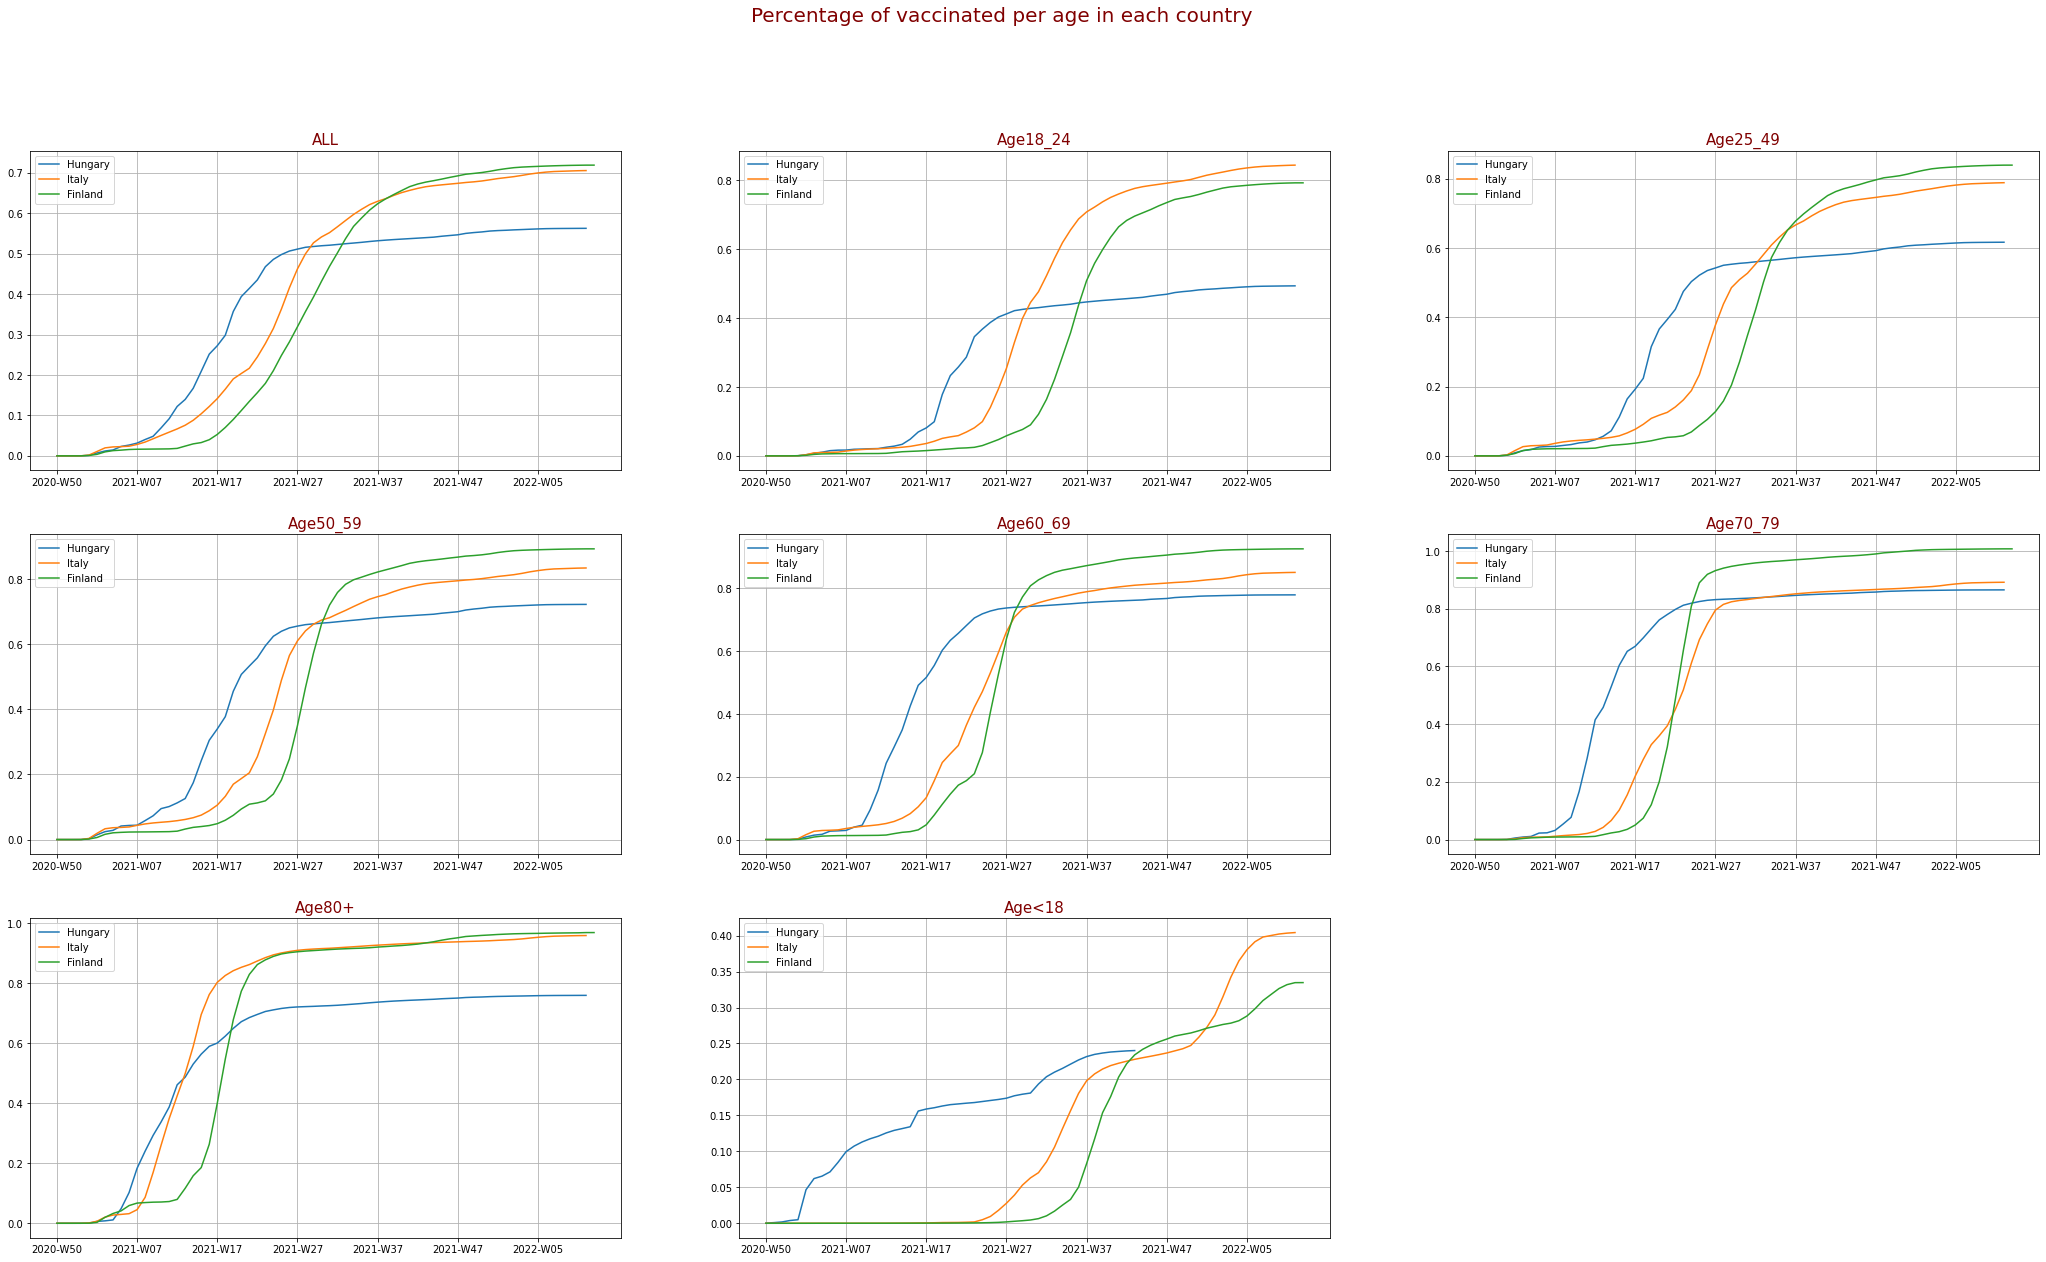

In [ ]:
fig = plt.figure(figsize = (36,20))
fig.suptitle("Percentage of vaccinated per age in each country", fontsize = 20, color='maroon')
i=1
while i < 9:
  for age in ages:
    ax = fig.add_subplot(3,3,i)
    ax.set_title(age, color = 'maroon', fontsize = 15)
    xticks_details(xticks,ax,10,0)
    ax.grid()
    for state in int_stat:
      try:
        ter = covid_data_xage_pct.loc[:,state,age].cumsum()['SecondDose'] / covid_data_xage_pct.loc[:,state,age].mean()['Denominator']
        ax.plot(ter.values, label = state)
      except:
        continue
    ax.legend(loc='best')
    i+=1

# Analysis of vaccines' effect

### Effect of vaccinations on some interest variables 


*   analysis of linear regression coefficients




In [ ]:
covid3_three = covid_data_3.set_index('location').loc[int_stat].reset_index()
covid_three_interest = covid3_three.groupby('location').max()
covid_three_interest_var = covid_three_interest[['total_cases','total_tests','total_vaccinations','population']]

# graph 1

covid_three_interest_var_totals = covid_three_interest[['total_cases','total_tests','total_vaccinations']]


# graph 2
covid3_three = covid_data_3.set_index('location').loc[['Italy','Finland','Hungary']].reset_index()
covid_three_interest = covid3_three.groupby('location').max()

covid_three_interest_var = covid_three_interest[['total_cases','total_tests','total_vaccinations','population']]
covid_three_interest_var['total_cases_percapita'] = covid_three_interest_var['total_cases']/covid_three_interest_var['population']
covid_three_interest_var['total_tests_percapita'] = covid_three_interest_var['total_tests']/covid_three_interest_var['population']
covid_three_interest_var['total_vaccinations_percapita'] = covid_three_interest_var['total_vaccinations']/covid_three_interest_var['population']

covid_three_interest_var.reset_index()
covid_three_interest_var_plot = covid_three_interest_var[['total_cases_percapita','total_tests_percapita','total_vaccinations_percapita']]

# plotting
# graph 1
covid_three_interest_var_totals.plot(kind = 'bar')

# graph 2
covid_three_interest_var_plot.plot(kind = 'bar')

In [ ]:
data_since_vacc = covid_data_2.set_index(['continent','location','date']).filter(regex='_per_million$', axis=1).reset_index()
data_since_vacc = data_since_vacc[data_since_vacc['date'] >= '2020-11-15']

In [ ]:
for_graph_1 = data_since_vacc.drop('continent', axis=1).set_index(['location','date']).filter(regex = '^new_.+_smoothed', axis=1)
fig = plt.figure(figsize = (30,9))
xticks = for_graph_1.reset_index('location').index.unique()
i=1
fig.suptitle('Covid impact in interest countries', fontsize = 20, color='maroon')
for state in int_stat:
    ter = for_graph_1.loc[state,:] 
    while i < 4:
      ax = fig.add_subplot(1,3,i)
      ax.plot(ter['new_deaths_smoothed_per_million'],'k--', label ='new_deaths')
      ax2 = ax.twinx()
      ax2.plot(ter['new_vaccinations_smoothed_per_million'], 'b--', label = 'new_vaccinations',)
      ax2.plot(ter['new_cases_smoothed_per_million'],'g--', label ='new_cases')
      ax.legend(loc='upper right')
      ax2.legend(loc='upper left')
      ax.set_title(state, color = 'maroon', fontsize = 15)
      xticks_details(xticks,ax,50,45)
      break
    i += 1

In [ ]:
for_graph_2 = data_since_vacc.drop('continent', axis=1).set_index(['location','date']).filter(['icu_patients_per_million','hosp_patients_per_million','new_vaccinations_smoothed_per_million'], axis=1)
fig = plt.figure(figsize = (30,9))
xticks = for_graph_2.reset_index('location').index.unique()
i=1
fig.suptitle('Covid impact on health structures in interest countries', fontsize = 20, color='maroon')
for state in int_stat:
    ter = for_graph_2.loc[state,:] 
    while i < 4:
      ax = fig.add_subplot(1,3,i)
      ax.plot(ter['new_vaccinations_smoothed_per_million'],'b--', label ='new_vaccinations')
      ax2 = ax.twinx()
      ax2.plot(ter['icu_patients_per_million'], 'r--', label = 'icu_patients',)
      ax2.plot(ter['hosp_patients_per_million'],'y--', label ='hosp_patients')
      ax.legend(loc='upper right')
      ax2.legend(loc='upper left')
      ax.set_title(state, color = 'maroon', fontsize = 15)
      xticks_details(xticks,ax,50,45)
      break
    i += 1

In [ ]:
import re
y_vars = []
col = list(covid_data_2.columns)
for i in col:
    if re.match('^new_.+_smoothed$|^.+_patients$|^.+[^h]_rate$',i):
        y_vars.append(i)
y_vars = y_vars[:-2]
df_ita = coeff_df(covid_data_2, loc_col='location', state = 'Italy', y_vars = y_vars, x_name = 'new_vaccinations_smoothed')
df_hun = coeff_df(covid_data_2, loc_col='location', state = 'Hungary', y_vars = y_vars, x_name = 'new_vaccinations_smoothed')
df_fin = coeff_df(covid_data_2, loc_col='location', state = 'Finland', y_vars = y_vars, x_name = 'new_vaccinations_smoothed')
df_semi = pd.merge(df_ita,df_hun, on = 'Dependant_variables', suffixes=('_Italy', '_Hungary'))
df_tot = pd.merge(df_semi,df_fin, on = 'Dependant_variables').rename(columns={'Beta_hat': 'Beta_hat_Finland'}).set_index('Dependant_variables')
df_tot.loc['icu_patients'] = [df_ita['Beta_hat'].iloc[3], np.NaN, np.NaN]
# I add the effect of vaccinations on hospitalized in intensive care for Italy --> I think it's interesting
df_tot